<a href="https://colab.research.google.com/github/kotireddys/masters_thesis/blob/main/Thesis4_Radaraltimeter_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 91.2 MB/s eta 0:00:00
DEM shape: (27962, 18470)  |  Resolution: 0.02 m/pixel
Elevation range: -9999.00 – 29.90 m
✅ Synthetic radar data saved → /content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/simulated_radar_usd1.csv
Total samples: 7388 | Valid: 2768


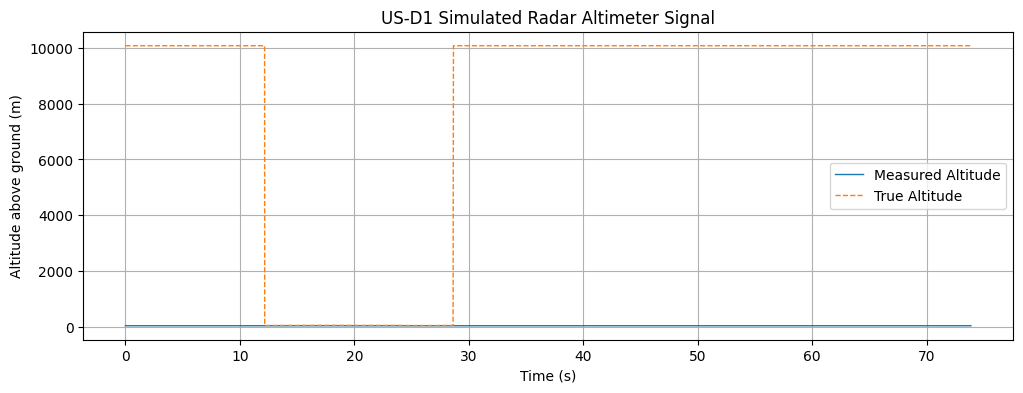

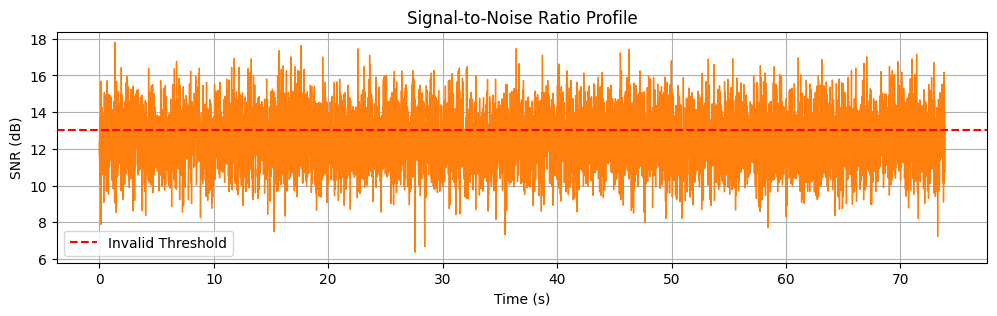

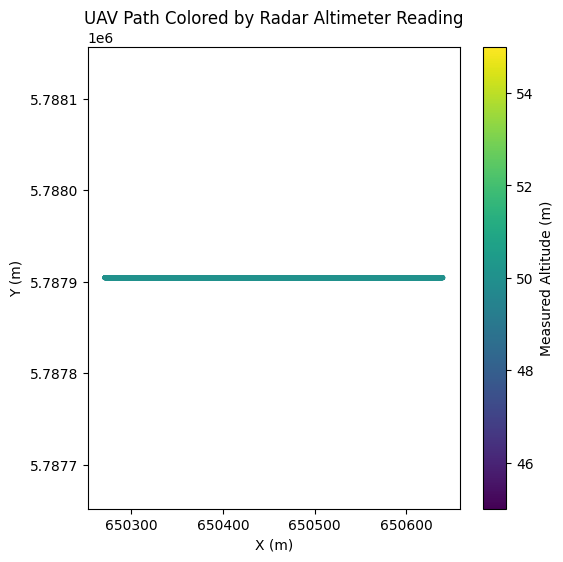

In [ ]:
# ================================================================
#  Ainstein US-D1 Radar Altimeter  (Single-Beam)  Synthetic Simulation
# ================================================================
!pip install rasterio
import numpy as np
import pandas as pd
import rasterio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

# ------------------ USER CONFIGURATION ------------------
DEM_PATH = "/content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/dem_footprint_cropped.tif"
ALTITUDE_MSL = 70.0        # UAV nominal altitude above mean sea level (m)
SAMPLE_RATE = 100          # Hz
VELOCITY = 5.0             # m/s horizontal UAV speed
NOISE_SCALE = 0.005        # 0.5% of reading (datasheet)
RANGE_LIMITS = (0.5, 50.0) # valid range in meters
SNR_THRESHOLD = 13         # dB
STEP = 2.0                 # horizontal step (m) between samples for map display
# ---------------------------------------------------------

# === 1. LOAD DEM ===
with rasterio.open(DEM_PATH) as src:
    dem = src.read(1)
    transform = src.transform
    x = np.arange(src.width) * transform[0] + transform[2]
    y = np.arange(src.height) * transform[4] + transform[5]
    y = np.flip(y)  # ensure north-up
    dem = np.flipud(dem)
    res = abs(transform[0])

print(f"DEM shape: {dem.shape}  |  Resolution: {res:.2f} m/pixel")
print(f"Elevation range: {np.nanmin(dem):.2f} – {np.nanmax(dem):.2f} m")

interp = RegularGridInterpolator((y, x), dem, bounds_error=False, fill_value=np.nan)

# === 2. SYNTHETIC UAV TRAJECTORY ===
# Straight-line flight from left → right across DEM center
flight_y = np.mean(y)
x_path = np.linspace(x.min(), x.max(), int((x.max()-x.min())/res))
y_path = np.full_like(x_path, flight_y)

distance = np.linalg.norm([x.max()-x.min()])
duration = distance / VELOCITY
t = np.arange(0, duration, 1/SAMPLE_RATE)

# match sampling points to time
idx = np.linspace(0, len(x_path)-1, len(t)).astype(int)
x_t, y_t = x_path[idx], y_path[idx]

# === 3. COMPUTE TRUE GROUND + TRUE RADAR RANGE ===
z_ground = interp(np.column_stack((y_t, x_t)))
z_uav = np.full_like(z_ground, ALTITUDE_MSL)
h_true = z_uav - z_ground

# === 4. ADD SENSOR NOISE & QUANTIZATION (±0.5%) ===
sigma = NOISE_SCALE * h_true
noise = np.random.normal(0, sigma)
h_meas = h_true + noise
h_meas = np.clip(h_meas, *RANGE_LIMITS)
# 1 cm quantization
h_meas = 0.01 * np.round(h_meas / 0.01)

# === 5. GENERATE SNR + INVALID FLAG ===
SNR = 30 - 0.35*h_meas + np.random.normal(0, 1.5, size=h_meas.shape)
valid = (SNR >= SNR_THRESHOLD) & np.isfinite(h_meas)

# === 6. BUILD DATAFRAME ===
df = pd.DataFrame({
    "time_s": t,
    "x_m": x_t,
    "y_m": y_t,
    "z_ground_m": z_ground,
    "z_uav_m": z_uav,
    "radar_true_m": h_true,
    "radar_meas_m": h_meas,
    "SNR_dB": SNR,
    "valid": valid.astype(int)
})
CSV_PATH = "/content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/simulated_radar_usd1.csv"
df.to_csv(CSV_PATH, index=False)
print(f"✅ Synthetic radar data saved → {CSV_PATH}")
print(f"Total samples: {len(df)} | Valid: {df.valid.sum()}")

# === 7. VISUALIZATION ===
plt.figure(figsize=(12,4))
plt.plot(df["time_s"], df["radar_meas_m"], label="Measured Altitude", lw=1)
plt.plot(df["time_s"], df["radar_true_m"], '--', label="True Altitude", lw=1)
plt.xlabel("Time (s)"); plt.ylabel("Altitude above ground (m)")
plt.title("US-D1 Simulated Radar Altimeter Signal")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,3))
plt.plot(df["time_s"], df["SNR_dB"], c="tab:orange", lw=1)
plt.axhline(SNR_THRESHOLD, color='r', linestyle='--', label='Invalid Threshold')
plt.xlabel("Time (s)"); plt.ylabel("SNR (dB)")
plt.title("Signal-to-Noise Ratio Profile")
plt.legend(); plt.grid(True); plt.show()

# Map view
plt.figure(figsize=(6,6))
plt.scatter(df["x_m"], df["y_m"], c=df["radar_meas_m"],
            s=6, cmap="viridis", label="Radar Altitude (m)")
plt.colorbar(label="Measured Altitude (m)")
plt.xlabel("X (m)"); plt.ylabel("Y (m)")
plt.title("UAV Path Colored by Radar Altimeter Reading")
plt.axis("equal"); plt.show()


DEM shape: (27962, 18470), resolution: 0.02m
Elevation range: 2.65–29.90 m
Total scan points: 8288
✅ Saved radar-derived elevation map → /content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/simulated_radar_elevation.tif
✅ Saved radar grid readings → /content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/simulated_radar_grid.csv


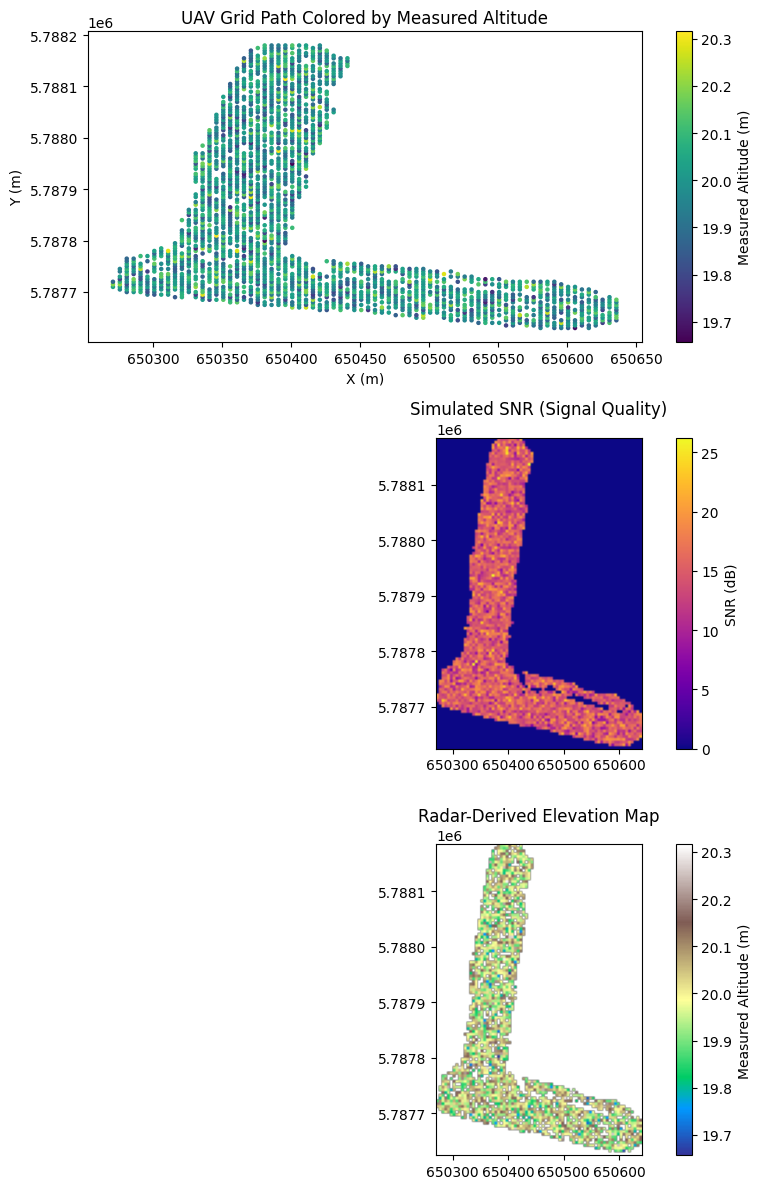

In [ ]:
# ================================================================
# 🛰️ Synthetic Radar Altimeter Simulation (Grid-Based Path)
# ================================================================

import rasterio
from rasterio.transform import from_origin
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- USER PATHS ---
DEM_PATH = "/content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/dem_footprint_cropped.tif"
SAVE_DIR = "/content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/"
os.makedirs(SAVE_DIR, exist_ok=True)

# --- RADAR PARAMETERS (Ainstein US-D1) ---
RADAR_ALT_RANGE = (0.5, 50)         # meters
SNR_THRESHOLD = 12                  # dB (minimum valid)
SNR_MEAN = 15                       # mean signal strength
SNR_NOISE = 3                       # std deviation
ALT_NOISE_STD = 0.1                 # radar measurement noise (m)
FLIGHT_ALTITUDE = 20.0              # UAV above ground (m)
GRID_SPACING = 5                    # m between scan lines

# ================================================================
# 1️⃣ Load DEM
# ================================================================
with rasterio.open(DEM_PATH) as src:
    dem = src.read(1).astype(float)
    transform = src.transform
    dem[dem < -1000] = np.nan
    xres, yres = src.res
    xmin, ymin, xmax, ymax = src.bounds
    print(f"DEM shape: {dem.shape}, resolution: {xres:.2f}m")
    print(f"Elevation range: {np.nanmin(dem):.2f}–{np.nanmax(dem):.2f} m")

# ================================================================
# 2️⃣ Generate 2D Grid Flight Path (Lawn-Mower Pattern)
# ================================================================
x_points = np.arange(xmin, xmax, GRID_SPACING)
y_points = np.arange(ymin, ymax, GRID_SPACING)
xx, yy = np.meshgrid(x_points, y_points)
coords = np.vstack([xx.ravel(), yy.ravel()]).T

print(f"Total scan points: {len(coords)}")

# ================================================================
# 3️⃣ Simulate Radar Altimeter Measurements
# ================================================================
measured_alt = []
true_alt = []
snr_list = []

for x, y in coords:
    # Convert world -> pixel indices
    px = int((x - xmin) / xres)
    py = int((ymax - y) / yres)

    if 0 <= px < dem.shape[1] and 0 <= py < dem.shape[0]:
        ground_z = dem[py, px]
        if np.isnan(ground_z):
            measured_alt.append(np.nan)
            true_alt.append(np.nan)
            snr_list.append(0)
            continue

        # True radar altitude
        true_h = FLIGHT_ALTITUDE
        # Simulate realistic SNR
        snr = np.random.normal(SNR_MEAN, SNR_NOISE)
        # Measurement noise
        measured_h = true_h + np.random.normal(0, ALT_NOISE_STD)
        # Invalidate weak signals
        if snr < SNR_THRESHOLD:
            measured_h = np.nan

        measured_alt.append(measured_h)
        true_alt.append(true_h)
        snr_list.append(snr)
    else:
        measured_alt.append(np.nan)
        true_alt.append(np.nan)
        snr_list.append(0)

# ================================================================
# 4️⃣ Convert to Maps
# ================================================================
rows = len(y_points)
cols = len(x_points)
radar_map = np.array(measured_alt).reshape(rows, cols)
snr_map = np.array(snr_list).reshape(rows, cols)

# Save radar elevation map as GeoTIFF
radar_path = os.path.join(SAVE_DIR, "simulated_radar_elevation.tif")
transform_radar = from_origin(xmin, ymax, GRID_SPACING, GRID_SPACING)
with rasterio.open(
    radar_path,
    "w",
    driver="GTiff",
    height=radar_map.shape[0],
    width=radar_map.shape[1],
    count=1,
    dtype=str(radar_map.dtype),
    crs=src.crs,
    transform=transform_radar,
) as dst:
    dst.write(np.nan_to_num(radar_map), 1)
print(f"✅ Saved radar-derived elevation map → {radar_path}")

# Save tabular data
df = pd.DataFrame({
    "x": coords[:,0],
    "y": coords[:,1],
    "true_alt": true_alt,
    "measured_alt": measured_alt,
    "snr": snr_list
})
csv_path = os.path.join(SAVE_DIR, "simulated_radar_grid.csv")
df.to_csv(csv_path, index=False)
print(f"✅ Saved radar grid readings → {csv_path}")

# ================================================================
# 5️⃣ Visualization
# ================================================================
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# --- 1. Path Colored by Measured Altitude ---
sc1 = axs[0].scatter(df["x"], df["y"], c=df["measured_alt"],
                     cmap="viridis", s=5)
axs[0].set_title("UAV Grid Path Colored by Measured Altitude")
axs[0].set_xlabel("X (m)")
axs[0].set_ylabel("Y (m)")
plt.colorbar(sc1, ax=axs[0], label="Measured Altitude (m)")

# --- 2. SNR Heatmap ---
im2 = axs[1].imshow(snr_map, cmap="plasma", extent=[xmin, xmax, ymin, ymax],
                    origin="lower")
axs[1].set_title("Simulated SNR (Signal Quality)")
plt.colorbar(im2, ax=axs[1], label="SNR (dB)")

# --- 3. Radar-Derived Elevation Map ---
im3 = axs[2].imshow(radar_map, cmap="terrain", extent=[xmin, xmax, ymin, ymax],
                    origin="lower")
axs[2].set_title("Radar-Derived Elevation Map")
plt.colorbar(im3, ax=axs[2], label="Measured Altitude (m)")

plt.tight_layout()
plt.show()


Quantitative Evaluation Methods

a) RMSE, MAE, and R²

In [ ]:
!pip install rasterio
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# --- Open both rasters ---
lidar_path = "/content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/dem_footprint_cropped.tif"
radar_path = "/content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/simulated_radar_elevation.tif"

with rasterio.open(lidar_path) as src1:
    lidar = src1.read(1).astype(np.float32)
    lidar_meta = src1.meta.copy()

with rasterio.open(radar_path) as src2:
    radar = src2.read(1).astype(np.float32)
    radar_meta = src2.meta.copy()

# --- Prepare an empty array to store the resampled radar ---
radar_resampled = np.empty_like(lidar, dtype=np.float32)

# --- Reproject radar map to LiDAR grid ---
reproject(
    source=radar,
    destination=radar_resampled,
    src_transform=src2.transform,
    src_crs=src2.crs,
    dst_transform=src1.transform,
    dst_crs=src1.crs,
    resampling=Resampling.bilinear
)

# --- Compute metrics only on valid pixels ---
mask = np.isfinite(lidar) & np.isfinite(radar_resampled)
rmse = np.sqrt(mean_squared_error(lidar[mask], radar_resampled[mask]))
mae = np.mean(np.abs(lidar[mask] - radar_resampled[mask]))
r2  = r2_score(lidar[mask], radar_resampled[mask])

print(f"✅ RMSE: {rmse:.3f} m | MAE: {mae:.3f} m | R²: {r2:.3f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 112.9 MB/s eta 0:00:00
